In [1]:
import os
import random

from fastai import *
from fastai.tabular import *
from fastai.callbacks.tracker import EarlyStoppingCallback, ReduceLROnPlateauCallback
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

%reload_ext autoreload
%autoreload 2

In [2]:
path = Path('data')

In [3]:
df = pd.read_csv(path/'train.csv')

In [4]:
test_df = pd.read_csv(path/'test.csv')

In [ ]:
df.head()

In [ ]:
test_df.head()

In [5]:
# From QuangHoàng
# https://www.kaggle.com/quanghm/fastai-1-0-tabular-learner-with-ensemble/notebook

class roc(Callback):
    '''
    ROC_AUC metric callback for fastai. Compute ROC score over each batch and returns the average over batches.
    TO DO: rolling average
    '''
    def on_epoch_begin(self, **kwargs):
        self.total = 0
        self.batch_count = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = F.softmax(last_output, dim=1)
        # roc_auc_score does not work on batches which does not contain both classes.
        try:
            roc_score = roc_auc_score(to_np(last_target), to_np(preds[:,1]))
            self.total += roc_score
            self.batch_count += 1
        except:
            pass
    
    def on_epoch_end(self, num_batch, **kwargs):
        self.metric = self.total/self.batch_count

In [10]:
bs = 2048
dep_var = 'target'
cat_names = []
cont_names = [c for c in df.columns if c not in ['ID_code', 'target']]
procs = [Normalize]

earlystop = partial(EarlyStoppingCallback, monitor='roc', min_delta=0.001, patience=4)
reduce_lr = partial(ReduceLROnPlateauCallback, monitor='roc', min_delta=0.001, patience=0, factor=0.25)

In [11]:
# From QuangHoàng
# https://www.kaggle.com/quanghm/fastai-1-0-tabular-learner-with-ensemble/notebook

random.seed(5683)
valid_idx = random.sample(list(df.index.values), int(len(df)*0.05))

# verify that positive sample distribution in validation set is similar to that of the whole data
df.iloc[valid_idx].target.sum() / len(valid_idx) , df.target.sum() / len(df)

(0.1028, 0.10049)

In [12]:
data = TabularDataBunch.from_df(path=path, df=df, 
                                dep_var=dep_var, 
                                valid_idx=valid_idx, 
                                cat_names=cat_names, 
                                cont_names=cont_names, 
                                bs=bs,
                                procs=procs,
                                test_df=test_df)

In [13]:
# create and load trained learner
# add .load('file') to end

learn = tabular_learner(data, 
                        layers=[512,256,128,64], 
                        ps=0.7, 
                        metrics=[accuracy, roc()],
                        callback_fns=[earlystop, reduce_lr])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


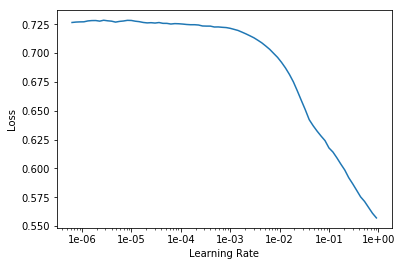

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(20, 1e-01)

epoch,train_loss,valid_loss,accuracy,roc,time
1,0.331772,0.248132,0.909200,0.851849,00:02
2,0.259606,0.236187,0.914200,0.857937,00:02
3,0.246598,0.240775,0.912400,0.860002,00:02
4,0.245909,0.248200,0.915100,0.854605,00:02
5,0.247675,0.238654,0.913800,0.861700,00:02
6,0.248449,0.238509,0.911700,0.858319,00:02
7,0.245987,0.236947,0.914200,0.856696,00:02
8,0.248423,0.264973,0.899100,0.853528,00:02
9,0.246241,0.251459,0.909100,0.855304,00:02
10,0.243224,0.239241,0.914700,0.864263,00:02


Epoch 4: reducing lr to 0.019
Epoch 6: reducing lr to 0.025
Epoch 7: reducing lr to 0.024686600155877186
Epoch 8: reducing lr to 0.023762115800336846
Epoch 9: reducing lr to 0.02227290443927625
Epoch 11: reducing lr to 0.017923575044782522
Epoch 13: reducing lr to 0.01250005
Epoch 14: reducing lr to 0.009718549451592768
Epoch 16: reducing lr to 0.004706458651255925
Epoch 17: reducing lr to 0.002727195560723751
Epoch 18: reducing lr to 0.0012379841996631572
Epoch 19: reducing lr to 0.00031349984412281387
Epoch 20: early stopping
Epoch 20: reducing lr to 1.0000000000000001e-07


In [16]:
learn.save('v5 roc 865')

---

**Find top 100 features**

In [ ]:
!pip install eli5

In [48]:
# Following 3 cells from 
# https://www.kaggle.com/mjbahmani/santander-ml-explainability

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance


cols=["target","ID_code"]
X = df.drop(cols,axis=1)
y = df["target"]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [49]:
rfc_model = RandomForestClassifier(random_state=0, verbose=3).fit(train_X, train_y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [50]:
perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)

In [58]:
%store perm
%store rfc_model

Stored 'perm' (PermutationImportance)
Stored 'rfc_model' (RandomForestClassifier)


In [ ]:
# eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=100)

In [87]:
top_weights = eli5.formatters.as_dataframe.explain_weights_df(perm, feature_names = val_X.columns.tolist())

In [88]:
var_list = [var for var in top_weights['feature']]

--------------

**Train new model on top features**

In [94]:
top_list = var_list[:100]

In [95]:
train_top = df[["ID_code", "target"] + top_list]
test_top = test_df[["ID_code"]+ top_list]

In [96]:
bs = 2048
cont_names = [c for c in train_top.columns if c not in ['ID_code', 'target']]

In [97]:
random.seed(5683)
valid_idx_top = random.sample(list(train_top.index.values), int(len(train_top)*0.05))

# verify that positive sample distribution in validation set is similar to that of the whole data
train_top.iloc[valid_idx_top].target.sum() / len(valid_idx_top) , train_top.target.sum() / len(train_top)

(0.1028, 0.10049)

In [98]:
data_top = TabularDataBunch.from_df(path=path, df=train_top, 
                                dep_var=dep_var, 
                                valid_idx=valid_idx_top, 
                                cat_names=cat_names, 
                                cont_names=cont_names, 
                                bs=bs,
                                procs=procs,
                                test_df=test_top)

In [99]:
learn_top = tabular_learner(data_top, 
                        layers=[400,200,100], 
                        ps=0.6, 
                        metrics=[accuracy, roc()],
                        callback_fns=[earlystop])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


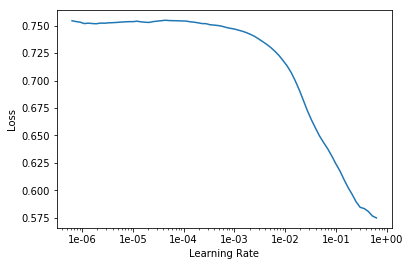

In [100]:
learn_top.lr_find()
learn_top.recorder.plot()

In [101]:
learn_top.fit_one_cycle(20, 1e-01)

epoch,train_loss,valid_loss,accuracy,roc,time
1,0.319969,0.272057,0.903600,0.803440,00:03
2,0.276263,0.275840,0.897100,0.810920,00:03
3,0.268390,0.306775,0.901300,0.804980,00:03
4,0.268903,0.292431,0.889300,0.805289,00:03
5,0.271625,0.264131,0.906400,0.810887,00:02
6,0.272066,0.274312,0.898500,0.812082,00:03
7,0.268356,0.283487,0.899500,0.812621,00:02
8,0.270012,0.266531,0.903000,0.811519,00:02
9,0.265475,0.272405,0.905400,0.813286,00:03
10,0.266668,0.260653,0.906000,0.815669,00:02


Epoch 18: early stopping


------

**Train new model on bottom features**

In [102]:
bot_list = var_list[100:]

In [103]:
train_bot = df[["ID_code", "target"] + bot_list]
test_bot = test_df[["ID_code"]+ bot_list]

In [104]:
bs = 2048
cont_names = [c for c in train_bot.columns if c not in ['ID_code', 'target']]

In [105]:
random.seed(5683)
valid_idx_bot = random.sample(list(train_bot.index.values), int(len(train_bot)*0.05))

# verify that positive sample distribution in validation set is similar to that of the whole data
train_bot.iloc[valid_idx_bot].target.sum() / len(valid_idx_bot) , train_bot.target.sum() / len(train_bot)

(0.1028, 0.10049)

In [106]:
data_bot = TabularDataBunch.from_df(path=path, df=train_bot, 
                                dep_var=dep_var, 
                                valid_idx=valid_idx_bot, 
                                cat_names=cat_names, 
                                cont_names=cont_names, 
                                bs=bs,
                                procs=procs,
                                test_df=test_bot)

In [107]:
learn_bot = tabular_learner(data_bot, 
                        layers=[400,200,100], 
                        ps=0.6, 
                        metrics=[accuracy, roc()],
                        callback_fns=[earlystop])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


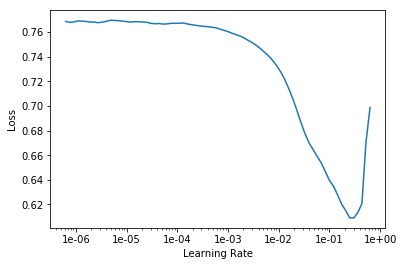

In [108]:
learn_bot.lr_find()
learn_bot.recorder.plot()

In [109]:
learn_bot.fit_one_cycle(20, 3e-02)

epoch,train_loss,valid_loss,accuracy,roc,time
1,0.431724,0.302908,0.898100,0.732084,00:03
2,0.315638,0.292361,0.899500,0.749434,00:03
3,0.295153,0.291751,0.900500,0.755861,00:03
4,0.289082,0.287351,0.899300,0.759743,00:03
5,0.288599,0.295014,0.899000,0.759349,00:03
6,0.287488,0.290241,0.900500,0.757910,00:03
7,0.285609,0.286874,0.899300,0.762635,00:03
8,0.285332,0.287265,0.899000,0.762142,00:03
9,0.284253,0.287644,0.900200,0.765599,00:03
10,0.282483,0.291460,0.898400,0.757056,00:03


Epoch 14: early stopping


---

**Add features to full df**

In [18]:
# https://www.kaggle.com/gpreda/santander-improved-starter-solution

def new_features(df, test_df):
    train_new = df
    test_new = test_df
    idx = [c for c in train_new.columns if c not in ['ID_code', 'target']]
    
    for df in [train_new, test_new]:
        df['sum'] = df[idx].sum(axis=1)
        df['sum_sq'] = df['sum']**2
        df['mad'] = df[idx].mad(axis=1)
        df['mean'] = df[idx].mean(axis=1)
        df['mean_sq'] = df['mean']**2
        df['sem'] = df[idx].sem(axis=1)
        df['std'] = df[idx].std(axis=1)
        df['skew'] = df[idx].skew(axis=1)
        df['kurt'] = df[idx].kurtosis(axis=1)
        
        
    print('Train and test shape:',train_new.shape, test_new.shape)
    return train_new, test_new

In [19]:
train_new, test_new = new_features(df, test_df)

Train and test shape: (200000, 211) (200000, 210)


In [20]:
bs = 2048
cont_names = [c for c in train_new.columns if c not in ['ID_code', 'target']]

In [21]:
random.seed(5683)
valid_idx_new = random.sample(list(train_new.index.values), int(len(train_new)*0.05))

# verify that positive sample distribution in validation set is similar to that of the whole data
train_new.iloc[valid_idx_new].target.sum() / len(valid_idx_new) , train_new.target.sum() / len(train_new)

(0.1028, 0.10049)

In [22]:
data_new = TabularDataBunch.from_df(path=path, df=train_new, 
                                dep_var=dep_var, 
                                valid_idx=valid_idx_new, 
                                cat_names=cat_names, 
                                cont_names=cont_names, 
                                bs=bs,
                                procs=procs,
                                test_df=test_new)

In [60]:
learn_new = tabular_learner(data_new, 
                        layers=[1000,100], 
                        ps=0.66, 
                        metrics=[accuracy, roc()],
                        callback_fns=[earlystop, reduce_lr])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


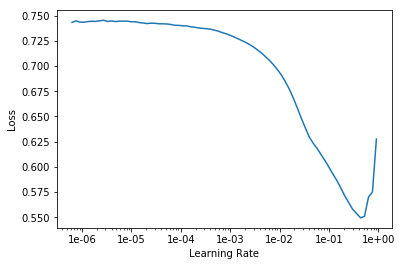

In [61]:
learn_new.lr_find()
learn_new.recorder.plot()

In [62]:
learn_new.fit_one_cycle(20, 3e-02)

epoch,train_loss,valid_loss,accuracy,roc,time
1,0.380562,0.240678,0.913400,0.855501,00:02
2,0.258041,0.229908,0.916700,0.865844,00:02
3,0.235354,0.234598,0.914800,0.866098,00:02
4,0.227529,0.233772,0.917500,0.869518,00:02
5,0.225055,0.266129,0.893300,0.871857,00:02
6,0.224071,0.227572,0.917200,0.868975,00:02
7,0.220917,0.238296,0.916500,0.869103,00:02
8,0.217562,0.238038,0.908600,0.870106,00:02
9,0.213611,0.228688,0.916400,0.872297,00:02


Epoch 3: reducing lr to 0.0039
Epoch 6: reducing lr to 0.0075
Epoch 7: reducing lr to 0.007405980046763155
Epoch 8: reducing lr to 0.0071286347401010525
Epoch 9: reducing lr to 0.006681871331782875
Epoch 10: early stopping
Epoch 10: reducing lr to 0.006088092404623223


In [63]:
learn_new.save('v5 roc872')

---

**Get Predictions**

In [64]:
preds, _ = learn_new.get_preds(ds_type=DatasetType.Test)

In [65]:
preds

tensor([[0.7973, 0.2027],
        [0.8239, 0.1761],
        [0.9073, 0.0927],
        ...,
        [0.9945, 0.0055],
        [0.9777, 0.0223],
        [0.9332, 0.0668]])

In [66]:
test_probs = np.array(preds[:, 1])

In [67]:
test_probs

array([0.202739, 0.176058, 0.092688, 0.134322, ..., 0.018886, 0.005465, 0.022348, 0.066793], dtype=float32)

In [68]:
sub_df = pd.DataFrame({'ID_code': test_df["ID_code"], 'target': test_probs})

In [69]:
sub_df.head()

,ID_code,target
0,test_0,0.202739
1,test_1,0.176058
2,test_2,0.092688
3,test_3,0.134322
4,test_4,0.038940


In [70]:
sub_df.to_csv('submission3.csv', index=False)